# 2. EDA

In [1]:
# Libraries imported for this notebook.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from scipy.stats import shapiro
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_Cleaned into a dataframe, formatted dates, and indexed dates.

df = pd.read_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned.xlsx', parse_dates=True, index_col=[0])

In [3]:
# Looked at shape.

df.shape

(53850, 5)

## Visualization

### Line plots

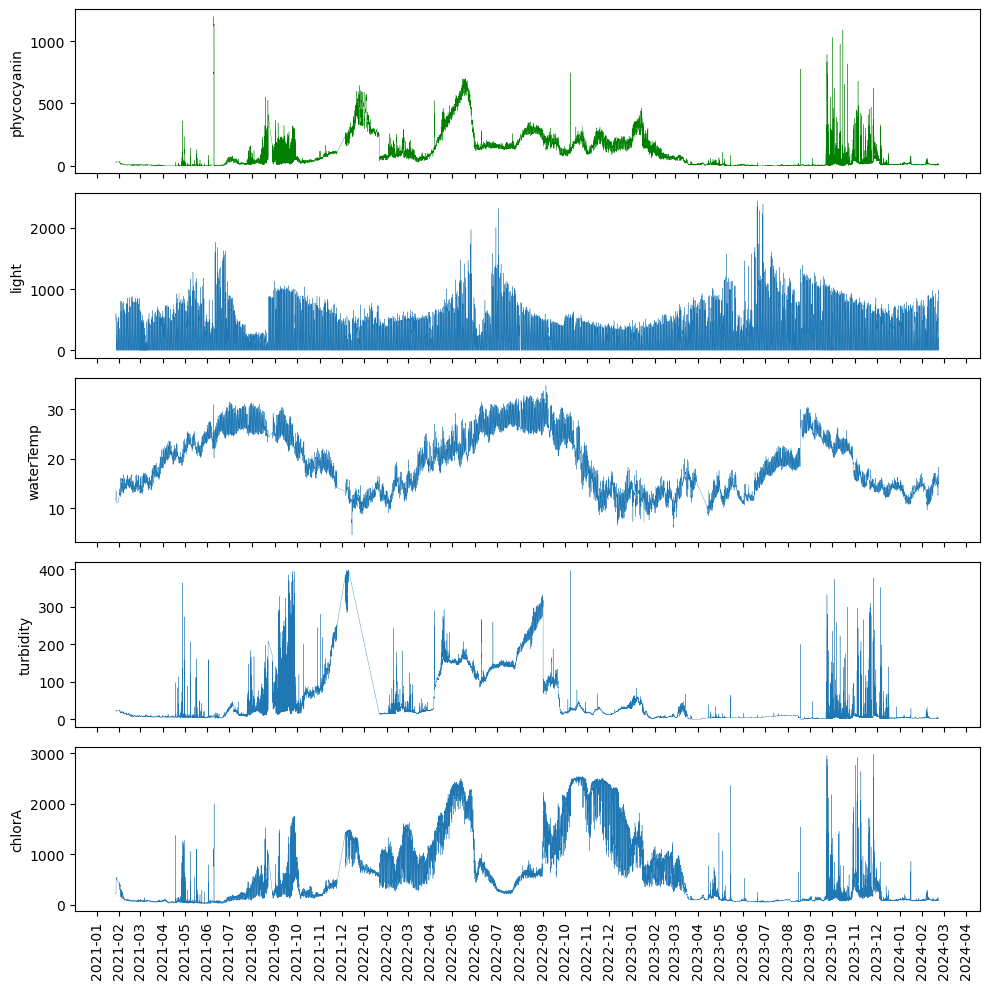

In [4]:
# Plotted data.

fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 2 * len(df.columns)), sharex=True)
for i, column in enumerate(df.columns):
    if i == 0:  # Checked if it's the first plot ('phycocyanin')
        axes[i].plot(df.index, df[column], linewidth=0.25, color='green')
    else:
        axes[i].plot(df.index, df[column], linewidth=0.25)
    axes[i].set_ylabel(column)
    axes[i].xaxis.set_major_locator(MonthLocator())
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Data looks complete and erroneous data has been fixed.
Observations from these plots:  
'phycocyanin' - Not seasonal. Often increased for a short period (day) but returned to zero, except for 12/21-2/22 and 4/22-6/22 when it stayed elevated. Baseline was higher in 11/21-4/23 than outside this range.  
'light' - Seasonal. Lowest in the winter and highest in the summer. June was cloudy every year and 2021 was also cloudy in July, Aug, and Dec.  
'waterTemp' - Seasonal. Lowest in the winter and highest in the summer.  
'turbidity' - Not seasonal. Followed similar pattern to 'phycocyanin'. Often increased for a short period (day) but returned to baseline, except for 10/21-2/22 and 4/22-10/22 when it stayed elevated. Baseline was higher in 11/21-4/23 than outside this range.  
'chlorA' - Not seasonal. Followed similar pattern to 'turbidity' and 'phycocyanin'. Often increased for a short period (day) but returned to zero except 12/21-2/22, 4/22-6/22, and 9/22-1/23 when it stayed elevated. Baseline was higher in 11/21-4/23 than outside this range. 

### Box plots

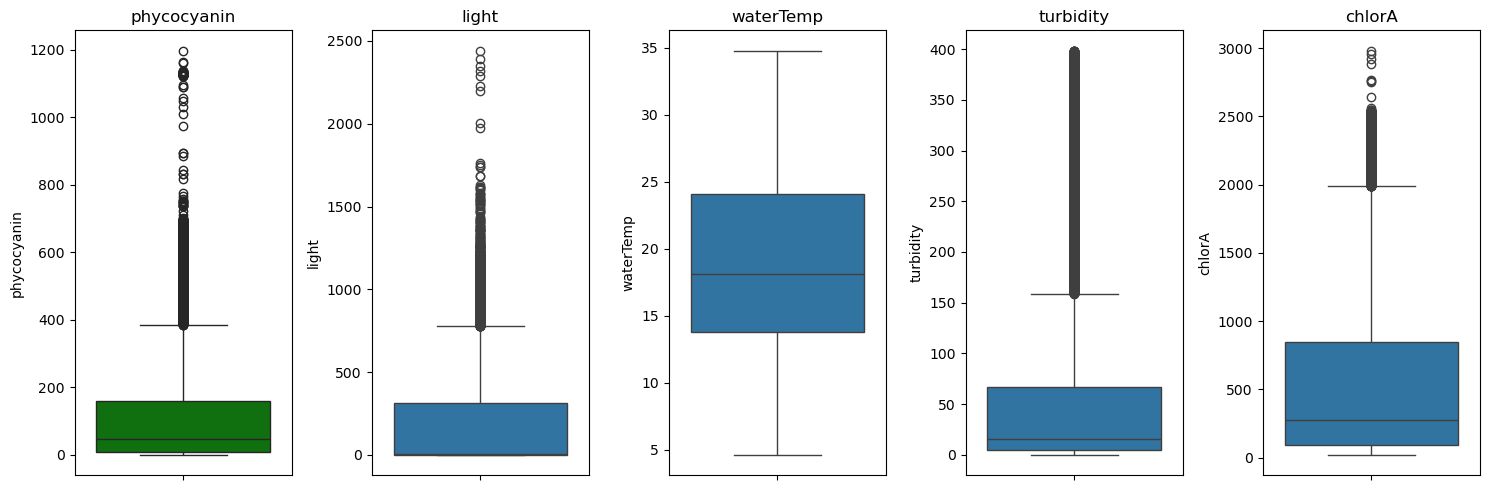

In [5]:
# Created boxplots for metrics.

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

# Created boxplots for each column
for i, column in enumerate(df.columns):
    if i == 0:  # Checked if it's the first plot ('phycocyanin')
        sns.boxplot(y=df[column], ax=axes[i], color='green')
    else:
        sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

This data is as expected. All values for 'waterTemp' fall withing the whiskers which are 1.5 times the IQR. Many values for 'phycocyanin', 'light', 'turbidity', and 'chlorA' are greater than the top whisker. As erroneous data has already been removed, there's no reason to believe that any of these data should be considred outliers.

### Histograms

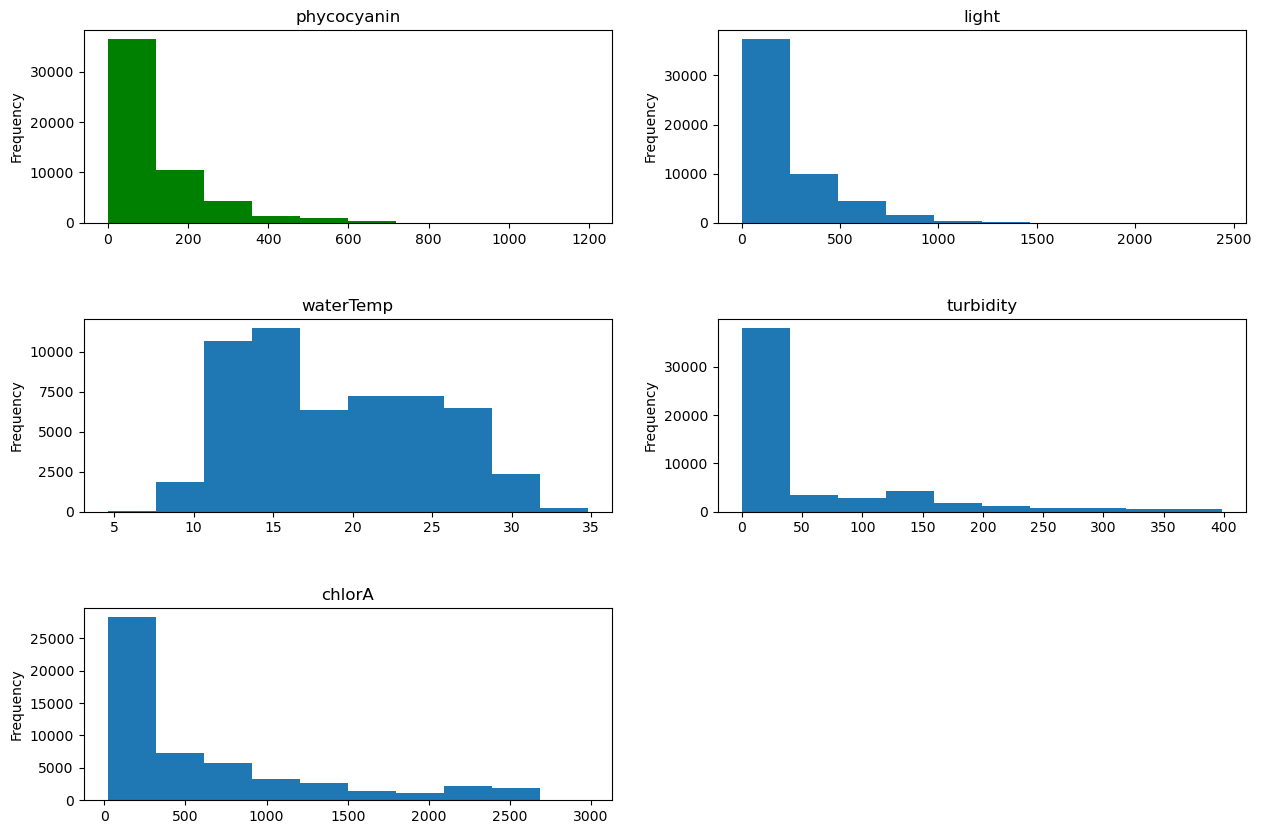

In [19]:
# Investigated distribution of data.

# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# Plot histogram for 'phycocyanin' column with green bars
df['phycocyanin'].plot(kind='hist', ax=axes[0, 0], color='green')
axes[0, 0].set_title('phycocyanin')

# Plot histograms for other columns
df['light'].plot(kind='hist', ax=axes[0, 1])
axes[0, 1].set_title('light')

df['waterTemp'].plot(kind='hist', ax=axes[1, 0])
axes[1, 0].set_title('waterTemp')

df['turbidity'].plot(kind='hist', ax=axes[1, 1])
axes[1, 1].set_title('turbidity')

df['chlorA'].plot(kind='hist', ax=axes[2, 0])
axes[2, 0].set_title('chlorA')

# Remove empty subplot
fig.delaxes(axes[2, 1])

plt.show()

These plots reflect the boxplots. Data for 'waterTemp' are the closest to being normally distibuted. All other data is right-skewed.

## Normality

In [20]:
# Performed Shapiro-Wilk test to see is metrics have a normal distribution.

for column in df.columns:
    stat, p_value = shapiro(df[column])
    print(f"Shapiro-Wilk test for {column}: Statistic={stat}, p-value={p_value}")

Shapiro-Wilk test for phycocyanin: Statistic=0.7642132639884949, p-value=0.0
Shapiro-Wilk test for light: Statistic=0.7447233200073242, p-value=0.0
Shapiro-Wilk test for waterTemp: Statistic=0.949253261089325, p-value=0.0
Shapiro-Wilk test for turbidity: Statistic=0.6761519908905029, p-value=0.0
Shapiro-Wilk test for chlorA: Statistic=0.773091733455658, p-value=0.0


/Users/NJahns/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


None of the metrics are not normally distributed.

## Correlations

### Heatmap

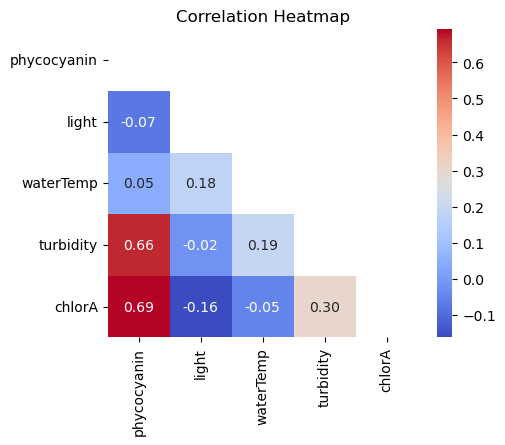

In [21]:
# Created correlatioin heatmap of metrics.

# Calculated correlation matrix
correlation_matrix = df.corr()

# Created a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotted heatmap with the mask
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title('Correlation Heatmap')
plt.show()

Some correlations were observed between the metrics. Moderately strong correlations occurred between 'phycocyanin' and 'turbidity' and between 'phycocyanin' and chlorA'. Moderately weak correlations occurred between 'turbidity' and chlorA'. The metrics correlated with 'phycocyanin' are likely to be good predictors in the models. Conversely, the metrics that are weakly correlation with 'phycocyanin' are likely to be less relevant in the model and could be excluded if needed during model development. No metric was very correlated (close to 1) with 'phycocyanin', which would have warranted removal from the data. 

### Pairplot

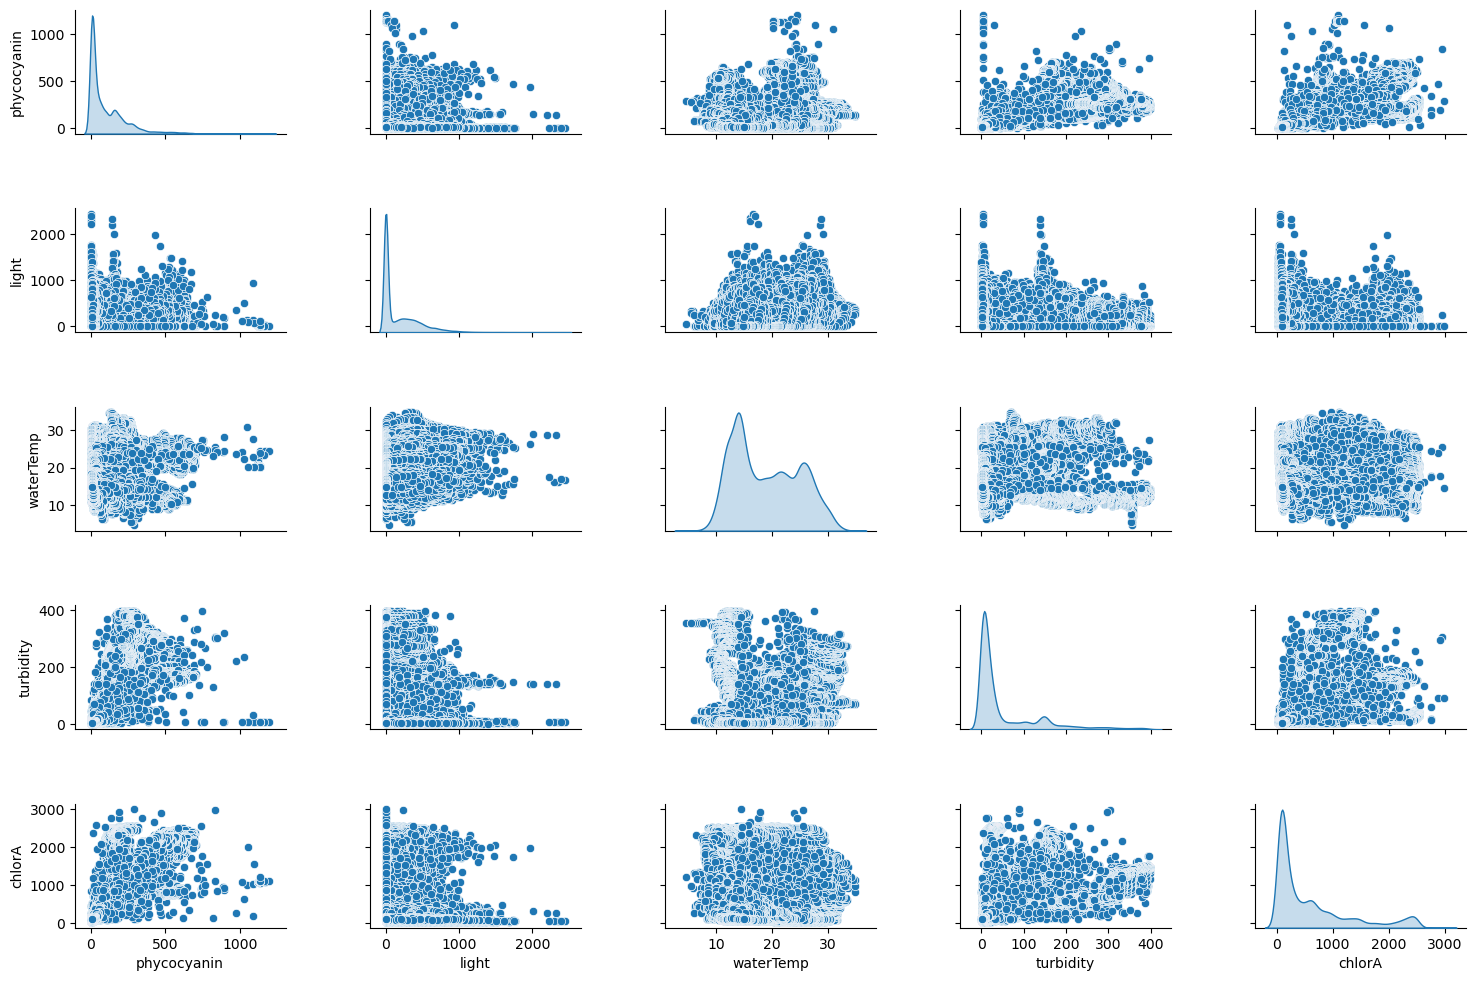

In [38]:
# Created pairplot of phycocyanin with other metrics.

pair_plot = sns.pairplot(df, kind='scatter', diag_kind='kde', height=2, aspect=1.5)
pair_plot.fig.subplots_adjust(wspace=0.4, hspace=0.6)

plt.show()

The pair plot agrees with the assssments of the correlation heatmap and the histograms.

## Stationarity

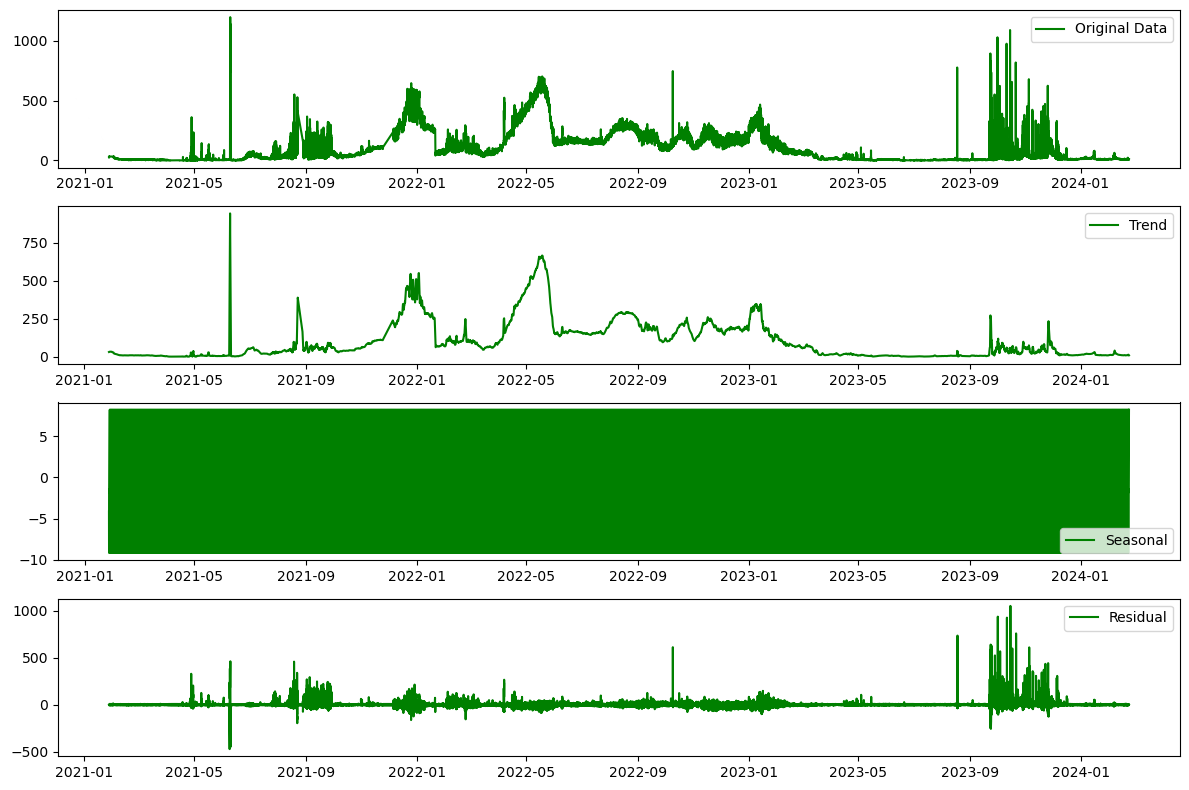

In [39]:
# Perform seasonal decomposition and plotted of 'phycocyanin'.

# Ensured datetime index is in the correct format
df.index = pd.to_datetime(df.index)

# Performed seasonal decomposition
decomposition = seasonal_decompose(df['phycocyanin'], model='additive', period=48)

# Plotted the original data, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['phycocyanin'], label='Original Data', color='green')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='green')
plt.legend()

plt.tight_layout()
plt.show()

I think the seasonal trend is showing daily variation but will have to zoom in to confirm.

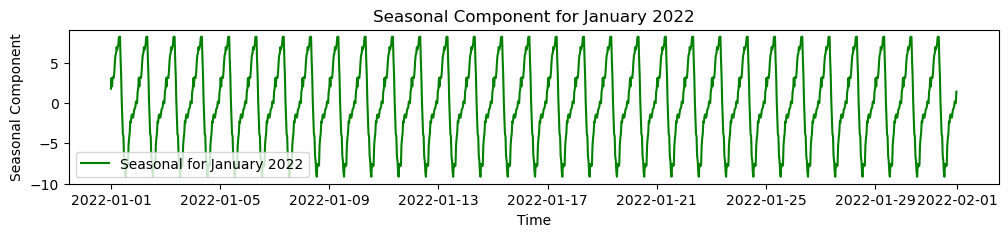

In [40]:
# Zoomed in on the seasonal data.

seasonal_jan_2022 = decomposition.seasonal['2022-01']

# Plotting
plt.figure(figsize=(12, 2))
plt.plot(seasonal_jan_2022, label='Seasonal for January 2022', color='green')
plt.legend()
plt.title('Seasonal Component for January 2022')
plt.xlabel('Time')
plt.ylabel('Seasonal Component')
plt.show()

'phycocyanin' decomosition observations:  
The trend plot shows no long-term progression or direction of the data over time.  
The seasonal plot shows a daily fluctuation pattern which occur in a regular pattern.  
The residual plot shows the random noise left in the data after removing the trend and seasonal components. Unexplained variability occurs periodically throughout the study period and is most intense in 10/23-1/24

Rather than print plots for all the metics, I will run KPSS and ADF tests for stationarity.

In [41]:
# Defined function to run KPSS test.

def kpss_test(timeseries, column_name):
    print('Results of KPSS Test for column "{}":'.format(column_name))
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)
    print()

In [42]:
# Ran KPSS for each metric.

for column in df.columns:
    kpss_test(df[column], column)

Results of KPSS Test for column "phycocyanin":
Test Statistic             5.389864
p-value                    0.010000
#Lags Used               137.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64

Results of KPSS Test for column "light":
Test Statistic             1.7957
p-value                    0.0100
#Lags Used               106.0000
Critical Value (10%)       0.3470
Critical Value (5%)        0.4630
Critical Value (2.5%)      0.5740
Critical Value (1%)        0.7390
dtype: float64

Results of KPSS Test for column "waterTemp":
Test Statistic             4.454738
p-value                    0.010000
#Lags Used               137.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64

Results of KPSS Test for column "turbidity":
Test Statistic             6.085

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_90303/3563013229.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_90303/3563013229.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_90303/3563013229.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_90303/35630132

The p-values for all metrics were <0.01 which is less than the significance level of 0.05. Therefore, I reject the null hypothesis of stationarity for all metrics. They are all likely non-stationary according to the KPSS test.

In [43]:
# Defined function to run ADF test.

def adf_test(timeseries, column_name):
    print('Results of ADF Test for column "{}":'.format(column_name))
    adftest = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)
    print()

In [44]:
# Ran ADF for each metric.

for column in df.columns:
    adf_test(df[column], column)

Results of ADF Test for column "phycocyanin":
Test Statistic                    -5.567825
p-value                            0.000001
#Lags Used                        58.000000
Number of Observations Used    53791.000000
Critical Value (1%)               -3.430472
Critical Value (5%)               -2.861594
Critical Value (10%)              -2.566799
dtype: float64

Results of ADF Test for column "light":
Test Statistic                -1.019467e+01
p-value                        6.191247e-18
#Lags Used                     5.800000e+01
Number of Observations Used    5.379100e+04
Critical Value (1%)           -3.430472e+00
Critical Value (5%)           -2.861594e+00
Critical Value (10%)          -2.566799e+00
dtype: float64

Results of ADF Test for column "waterTemp":
Test Statistic                    -2.582144
p-value                            0.096744
#Lags Used                        58.000000
Number of Observations Used    53791.000000
Critical Value (1%)               -3.430472
Cr

The p-value for the "waterTemp", "turbidity", and "chlorA" metrics are greater than 0.05. Therefore, I fail to reject the null hypothesis at the 5% significance level. This suggests that these metrics may have a unit root and could be non-stationary according to the ADF test.

The p-values are all less than 0.05 or the "phycocyanin" and "light" metrics, indicating strong evidence against the presence of a unit root. Thus, I reject the null hypothesis for these variables, suggesting that they are likely stationary according to the ADF test.

Together, the KPSS and ADF tests indicate that "waterTemp", "turbidity", and "chlorA" metrics are non-stationary. As for "phycocyanin" and "light" the KPSS test indicates that the metrics are non-stationary while the ADF test indicates that they are stationary. This apparent contradiction indicates that these three metrics are difference stationary. As a result, all metrics will need to be detrended through differencing techniques.

# Data Save

In [45]:
# Saved dataframe.

df.to_excel('Lake_Fictitious_AquaRealTime_Data_EDA.xlsx', index=True)